In [52]:
# ============================
# PREPROCESSING FOR CLUSTERING
# ============================
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("Dataset/student_performance_cleaned.csv")
df["Participation in Extracurricular Activities"] = df["Participation in Extracurricular Activities"].map({"Yes": 1, "No": 0})
df_clustering = df.drop(columns=["Student ID", "Passed"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_clustering.columns)
print("Preprocessing done!")
print(X_scaled_df.head())
print(X_scaled_df.describe())
X_scaled_df.to_csv("Dataset/student_clustering_scaled.csv", index=False)
print("File saved successfully!")

Preprocessing done!
   Study Hours per Week  Attendance Rate  Previous Grades  \
0             -0.132470         0.976820        -0.290718   
1              1.516602         0.071503        -0.182525   
2             -0.231812         0.683204         0.436583   
3             -0.231812        -0.075305         0.232217   
4              1.576207        -1.797854         1.692830   

   Participation in Extracurricular Activities  
0                                    -0.998903  
1                                     1.001098  
2                                    -0.998903  
3                                     1.001098  
4                                    -0.998903  
       Study Hours per Week  Attendance Rate  Previous Grades  \
count          3.098600e+04     3.098600e+04     3.098600e+04   
mean           2.311454e-16     1.055977e-15    -6.310063e-16   
std            1.000016e+00     1.000016e+00     1.000016e+00   
min           -3.887585e+00    -4.386571e+00    -3.434341e+

In [53]:
# ============================
# ELBOW METHOD (SSE)
# ============================
from sklearn.cluster import KMeans
sse = []
K_values = range(2, 11)
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    sse.append(kmeans.inertia_)
print("=== SSE Values for Each k ===")
for k, sse_value in zip(K_values, sse):
    print(f"k = {k}: SSE = {sse_value:,.2f}")

=== SSE Values for Each k ===
k = 2: SSE = 92,954.64
k = 3: SSE = 82,955.86
k = 4: SSE = 73,087.66
k = 5: SSE = 66,106.02
k = 6: SSE = 59,548.50
k = 7: SSE = 54,238.61
k = 8: SSE = 50,165.89
k = 9: SSE = 46,024.21
k = 10: SSE = 43,314.64


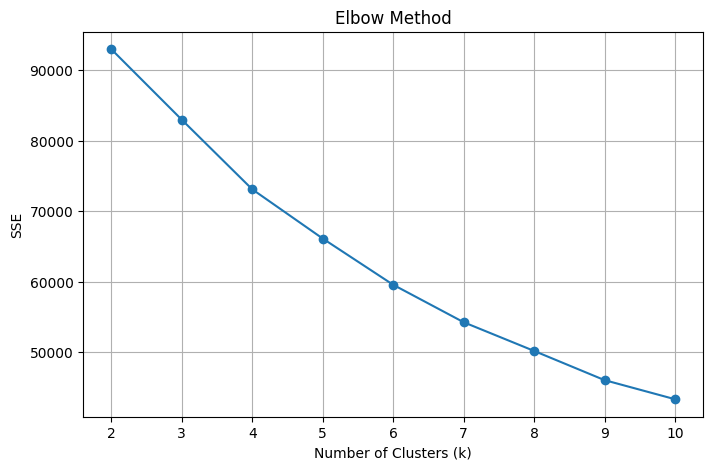

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(K_values, sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

In [55]:
# ============================
# SILHOUETTE SCORE
# ============================
from sklearn.metrics import silhouette_score

sil_scores = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)
    sil = silhouette_score(X_scaled_df, labels)
    sil_scores.append(sil)
    print(f"k={k}: Silhouette Score = {sil:.4f}")

k=2: Silhouette Score = 0.2829
k=3: Silhouette Score = 0.2258
k=4: Silhouette Score = 0.2099
k=5: Silhouette Score = 0.2089
k=6: Silhouette Score = 0.2125
k=7: Silhouette Score = 0.2162
k=8: Silhouette Score = 0.2189
k=9: Silhouette Score = 0.2221
k=10: Silhouette Score = 0.2200


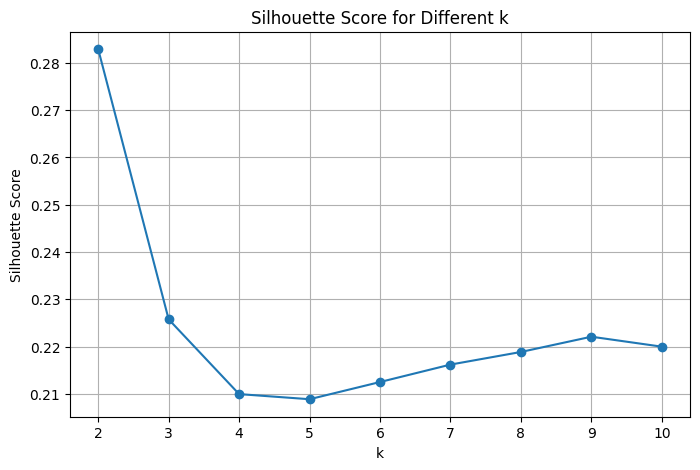

In [56]:
plt.figure(figsize=(8,5))
plt.plot(K_values, sil_scores, marker='o')
plt.title("Silhouette Score for Different k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [57]:
# ============================
# FINAL KMEANS (k = 2)
# ============================
best_k = 2
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled_df)
final_sil_score = silhouette_score(X_scaled_df, clusters)
print("Final Silhouette Score =", final_sil_score)
X_scaled_df["Cluster"] = clusters
cluster_centers = X_scaled_df.groupby("Cluster").mean()
cluster_centers


Final Silhouette Score = 0.28290241354353246


,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities
Cluster,,,,
0,-0.008435,-0.002494,-0.005546,-0.998903
1,0.008453,0.002499,0.005558,1.001098


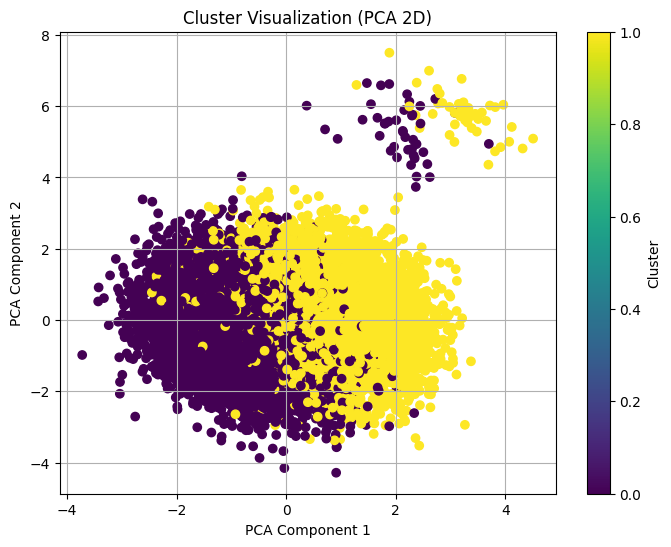

In [58]:
# ============================
# CLUSTER VISUALIZATION USING PCA
# ============================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled_df.drop(columns=["Cluster"]))

plt.figure(figsize=(8,6))
plt.scatter(pca_components[:,0], pca_components[:,1], c=X_scaled_df["Cluster"], cmap="viridis")
plt.title("Cluster Visualization (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


BCubed Precision: 1.000020991583855
BCubed Recall: 1.000020991583855


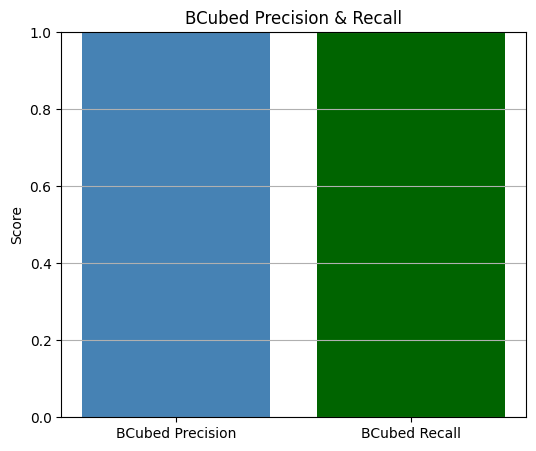

In [59]:
# ============================
# BCubed Visualization
# ============================
import pandas as pd
df_bc = pd.DataFrame({
    "true": true_labels,
    "pred": pred_labels
})
true_groups = df_bc.groupby("true").size()
pred_groups = df_bc.groupby("pred").size()
intersection = df_bc.groupby(["true", "pred"]).size()
b_precision_fast = sum(
    (intersection[(t, p)] / pred_groups[p]) * (intersection[(t, p)] / true_groups[t])
    for t, p in intersection.index
)
b_recall_fast = sum(
    (intersection[(t, p)] / true_groups[t]) * (intersection[(t, p)] / pred_groups[p])
    for t, p in intersection.index
)

print("BCubed Precision:", b_precision_fast)
print("BCubed Recall:", b_recall_fast)

plt.figure(figsize=(6,5))
plt.bar(["BCubed Precision", "BCubed Recall"], [b_precision, b_recall], color=["steelblue", "darkgreen"])
plt.ylabel("Score")
plt.title("BCubed Precision & Recall")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

We used K-Means as the unsupervised learning algorithm because it works well with numerical data, is simple to interpret, and allows clear evaluation using metrics like WCSS and the Silhouette Score. Our dataset is fully numeric after preprocessing, which makes it a good fit for K-Means, and the goal of this phase is to discover general patterns and student profiles rather than complex non-linear shapes. K-Means is also efficient with large datasets like ours and makes it straightforward to test different values of k using the elbow method.
BCubed Precision and Recall were tested for completeness, but the results were not meaningful because the clustering was performed after removing the class label, as required by the assignment. BCubed is designed to compare clustering performance against known ground-truth categories, which does not apply in this context since our clusters were created without using the “Passed” label. In contrast, the Silhouette Score and WCSS provide valid and useful evaluations for this dataset. The Silhouette Score helped assess how clearly separated the clusters are, and the results showed that k = 2 produced the highest (though still moderate) separation. WCSS (Within-Cluster Sum of Squares) allowed us to evaluate how compact the clusters are, and the elbow curve also supported choosing k = 2. Together, Silhouette and WCSS give a reliable understanding of cluster quality for this dataset, while BCubed does not offer meaningful insights due to the absence of true class labels during clustering.


Integration and Insights:
our k-means clustering with k=2 showed 2 student profiles:
• Cluster 0 (low engagement profile): below-average study hours per week, lower attendance rates, fewer previous grades, less participation in extracurricular activities, and represent students struggling with academics.
• Cluster 1 (high engagement profile): above-average study hours per week, higher attendance rates, better previous grades, more participation in extracurricular activities, and represents students with strong academic engagement.
we found multiple ways clusters can improve our supervised models: logistic regression, random forest, and extra trees.
1. Feature engineering enhancement: in phase 2, we created engineered features like Engagement_Score, Study_Efficiency, and Consistency. The cluster assignment can be added as a new feature as it summarizes the relationship between study hours, attendance, participation, and grades.
2. Cluster-specific modeling: instead of 1 model for all students, we can train random forest and extra trees for each cluster, improving F1-scores and reducing false negatives.
3. Anomaly detection: students with low silhouette scores do not fit either clusters, so they can be flagged to receive attention.